In [114]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Here I took the datapoints of commercial places of New York, United States. Earlier I was planning to choose Prayagraj-my hometown but eventually choose New York- a big city because of the availability of huge number of data. The following dataset is collected by taking reference from the given links.

https://towardsdatascience.com/loading-data-from-openstreetmap-with-python-and-the-overpass-api-513882a27fd0

https://wiki.openstreetmap.org/wiki/Overpass_API/Overpass_QL#By_tag_.28has-kv.29

https://mygeodata.cloud/osm/data/download/

Link to my dataset:
https://drive.google.com/file/d/1QgGJfIgFLkDDK0DtKenW7vLfkGLHJEy2/view?usp=sharing

In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

data_link = '/content/drive/My Drive/faces94/commercialplaces.xlsx'
df = pd.read_excel(data_link)
#to get rows and column
df.shape

(938, 34)

In [116]:
df.head()

,x,y,shop,name,addr:street,addr:housenumber,addr:postcode,opening_hours,phone,addr:city,addr:state,website,brand,wheelchair,delivery,brand:wikidata,brand:wikipedia,operator,addr:country,branch,name:en,payment:cash,drink:beer,payment:credit_cards,atm,ref,payment:debit_cards,fax,email,payment:american_express,payment:mastercard,payment:visa,payment:discover_card,organic
0,-73.883592,40.680115,supermarket,Bravo,Fulton Street,3008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-73.880406,40.681178,supermarket,Fair Fare,Fulton Street,3104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-73.833275,40.783704,department_store,Target College Point,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-73.911283,40.775434,supermarket,Key Food,31st Street,22-15,11105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-73.902183,40.778874,supermarket,Best Market,37th Street,19-30,NaN,NaN,(718) 721-7500,NaN,NaN,https://bestmarket.com/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Here x, y are latitude and longitude of our datapoints. We also have 32 other features. We can see that most of the other features have unfilled(**NaN**) values. We will drop them later.



In [117]:
df.describe()

,x,y
count,938.000000,938.000000
mean,-73.887648,40.734918
std,0.223921,0.070938
min,-74.405768,40.507436
25%,-73.991417,40.696936
50%,-73.950320,40.739456
75%,-73.835561,40.772154
max,-73.180649,40.892454


We took mean of our only numeric features(latitude and longitude) which comes to be -72.88 and 40.73 respectively. Here one thing is interesting to note is that the **standard deviation** of latitude(0.22) is significantly more than the **standard deviation** of longitude(0.07). This thing tells that ou***r commerical datapoints are distributed more horizontaly***. 

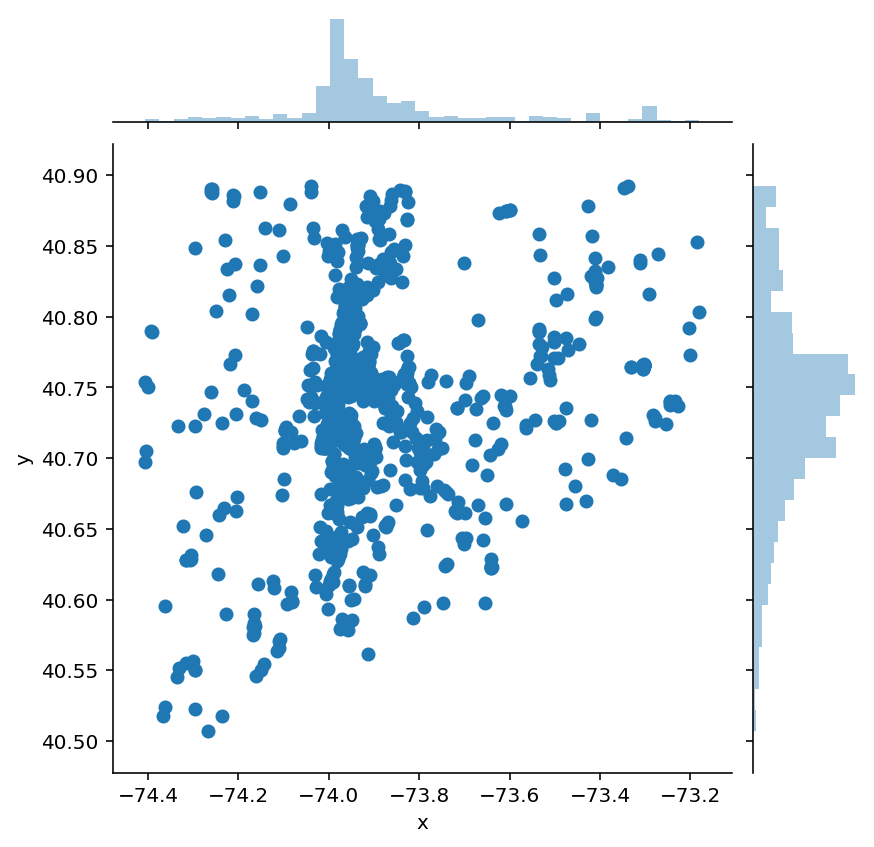

In [118]:
import seaborn as sns
%config InlineBackend.figure_format = 'retina'

sns.jointplot(x='x', y='y', data=df, kind='scatter');

Scatter plot showing density of datapoints. It can be seen that most of the commercial places are within a cluster where muliple shops are present. Generally in every city there is some this kind of hub. 

In [119]:
#cropping. Here I have taken only those columns which have more than 55% value filled.
totalpoints = df.shape[0]*0.55
df = df.dropna(thresh=totalpoints, axis=1)

#renaming columns to enhance readibility
df.rename(columns={'x':'latitude', 'y':'longitude', 'shop':'market_type','addr:street':'street'}, inplace=True)
df.head()

,latitude,longitude,market_type,name,street
0,-73.883592,40.680115,supermarket,Bravo,Fulton Street
1,-73.880406,40.681178,supermarket,Fair Fare,Fulton Street
2,-73.833275,40.783704,department_store,Target College Point,NaN
3,-73.911283,40.775434,supermarket,Key Food,31st Street
4,-73.902183,40.778874,supermarket,Best Market,37th Street


In [120]:
#checking number of rows to drop. If i have any point whose latitude or logitude value is not given, i will drop the whole row. 
df2 = df.dropna(thresh=938, axis=1)
df2.columns

Index(['latitude', 'longitude', 'market_type'], dtype='object')

Hence by performing above check statement, we can see that only columns which have zero NaN values are latitude, longitude and market_type. Here, we are mainly concern over fundamental geo-spatial coordinates, so we have to drop any row which have missing those values. 

In [121]:
unique_market_type = len(df['market_type'].unique().tolist())
unique_street = len(df['street'].unique().tolist())
print(unique_market_type,unique_street)
print(df['market_type'].unique().tolist())

6 291
['supermarket', 'department_store', 'kiosk', 'wholesale', 'mall', 'general']


Checking whether we can use **market_type**, **name** and **street** to cluster commercial points or not. We will see the number of distinct elements present in those object field. If there are too many distinction then we cannot use it for clustering. **Logic: If everything is different then on that ground(perticular feature) we can't cluster it**.  

Based on above output we can see that we can also form clusters based on unique_market_type. 



In [122]:
count = df.groupby(['market_type']).count()
count = count.iloc[:,0:1]
count.rename(columns={'latitude':'total_datapoints'})


,total_datapoints
market_type,
department_store,145
general,1
kiosk,30
mall,41
supermarket,714
wholesale,7


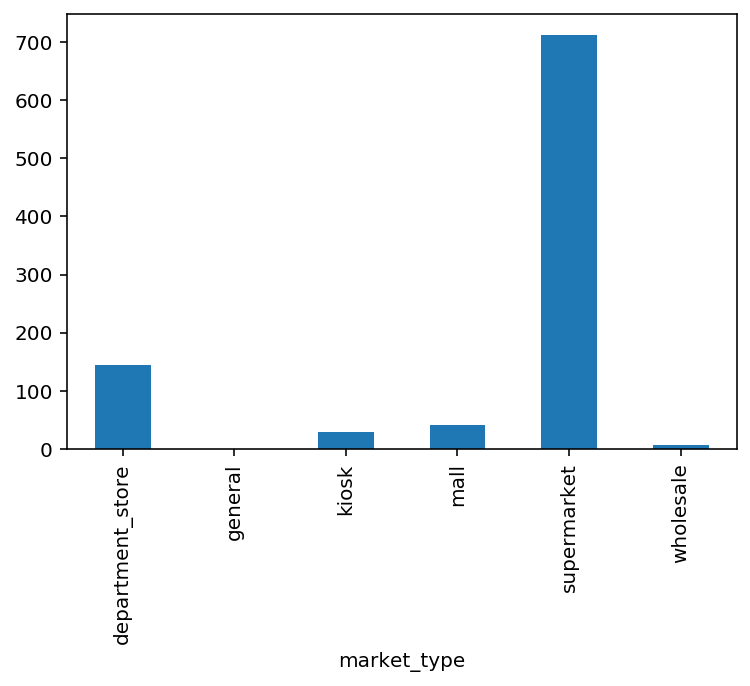

In [123]:
df.groupby('market_type')['latitude'].nunique().plot(kind='bar')

As we can see that distribution is uneven over market_type, so what we can cluster all data into two types i.e **supermarket and not supermarket**. After doing that we will have a comparable distinction between points.


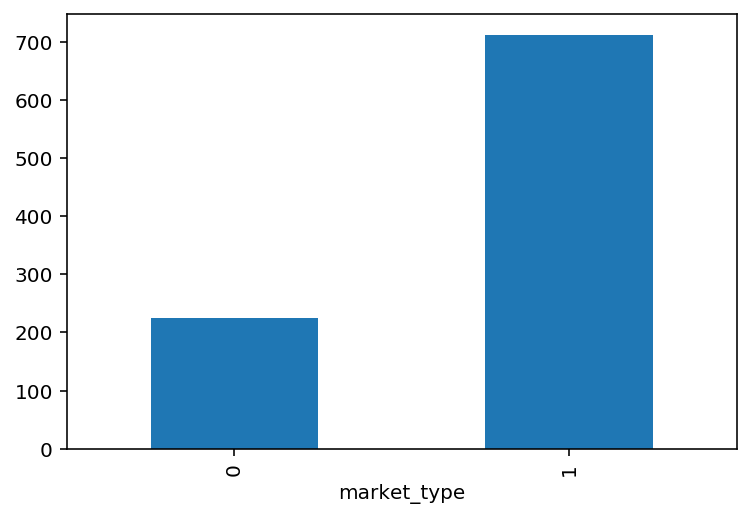

In [124]:
df['market_type'] = df['market_type'].replace('department_store', 0)
df['market_type'] = df['market_type'].replace('general', 0)
df['market_type'] = df['market_type'].replace('kiosk', 0)
df['market_type'] = df['market_type'].replace('mall', 0)
df['market_type'] = df['market_type'].replace('wholesale', 0)
df['market_type'] = df['market_type'].replace('supermarket', 1)

df.groupby('market_type')['latitude'].nunique().plot(kind='bar')

In [125]:
df.head()

,latitude,longitude,market_type,name,street
0,-73.883592,40.680115,1,Bravo,Fulton Street
1,-73.880406,40.681178,1,Fair Fare,Fulton Street
2,-73.833275,40.783704,0,Target College Point,NaN
3,-73.911283,40.775434,1,Key Food,31st Street
4,-73.902183,40.778874,1,Best Market,37th Street


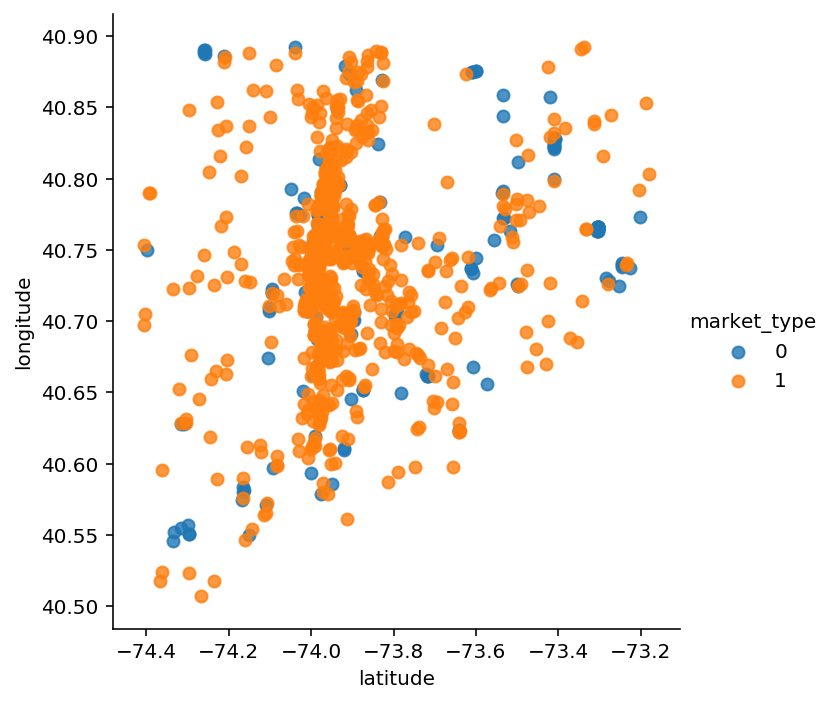

In [126]:
sns.lmplot('latitude', 'longitude', data=df, hue='market_type', fit_reg=False);

Scatterplot showing datapoints based on **market_type**. Remember we grouped all markets into **supermarket(1)** and **notSupermarket(0)**. Even after doing, we can still see that our datapoints are not in good proportion(this distribution is reminding me of  India's population based on religion).If we use market_type as label to classify our datapoints and keep our metric accuracy, then it wont be a good classification as our dataset is imbalanced.

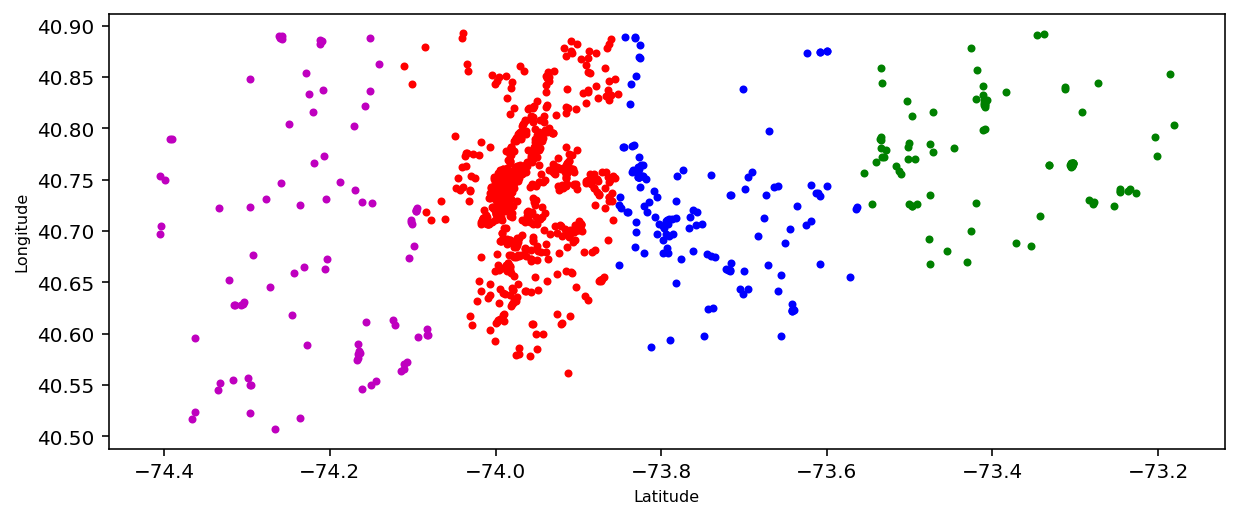

In [127]:
#A common clustering---Kmeans
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=0).fit(df.loc[:,['latitude','longitude']])
id_label=kmeans.labels_

ptsymb = np.array(['b.','r.','m.','g.','c.',]);
plt.figure(figsize=(10,4))
plt.ylabel('Longitude', fontsize=8)
plt.xlabel('Latitude', fontsize=8)
for i in range(4):
    cluster=np.where(id_label==i)[0]
    plt.plot(df.latitude[cluster].values,df.longitude[cluster].values,ptsymb[i])
plt.show()

Here I have clustered the data based on nearest neighbour concept. I took two features i.e latitude and longitude to cluster and as these two are location points and the algorithm which is best for clustering is KMeans. Here I kept K=4. If you ask me why four, then i will say that it's an assumption formed after the visualisation. That's why visualisation is done before predicting anything. **First see then judge.**




In [128]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

X = df.loc[:, 'latitude':'longitude']
# y = pd.get_dummies(df['market_type'])
y = df['market_type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=18)

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
f1_score(y_test, y_pred)  


0.8522483940042827

After getting the clusters, I have to classify the points based on commercial labels. I have already shown how I collected labels and how did I merge it to get binary labels. Even after merging, my labels are still unbalanced. Here I have used **Decision Tree Classifier** to classify datapoints. As the datapoints are unbalanced that's why I have used **F1_Score** instead of accuracy to measure the goodness of my model. 